In [2]:
import sys
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
import models_audio_mae

import numpy as np
import torchvision
import torch
import math
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import glob
from scipy import signal

In [3]:
# define the utils

def show_image(frequencies, times, spectrogram, title='', diffFlag=False):
    #plt.figure(figsize=(10, 5))
    plt.title(f'spectrogram from PSD: {title}')
    #plt.pcolormesh(times, frequencies, 10*np.log10(np.squeeze(spectrogram)), vmin=-150, vmax=-50)
    if not diffFlag:
      plt.pcolormesh(times, frequencies, 10*np.squeeze(spectrogram), vmin=-150, vmax=-50)
    else:
      plt.pcolormesh(times, frequencies, 10*np.squeeze(spectrogram))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(format="%+2.f", label='dB')
    return

def prepare_model(chkpt_dir, arch='audioMae_vit_base'):
    # build model
    model = getattr(models_audio_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(frequencies, times, spectrogram, model, test):
    
    #gnr_mean = 7.425835578987807e-08
    #gnr_std = 5.845655574487041e-07

    gnr_max = -4.203987498626368
    gnr_min = -19.198951409472006

    x = torch.transpose(spectrogram, 1, 2) #shape [1,80,100]
    #x = x - gnr_mean
    #x = x / gnr_std

    #MIN MAX SCALER
    x = (x -gnr_min) /(gnr_max-gnr_min) 

    # make it a batch-like
    x = x.unsqueeze(dim=0)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.8)
    #y = model_mae.unpatchify(y).detach().cpu()
    y = y.type(torch.float64)
    y = model.unpatchify(y).detach().cpu()
    
    y = torch.transpose(torch.squeeze(torch.squeeze(input=y)),0,1)


    #y = torch.squeeze(torch.squeeze(input=out))
    y = y * (gnr_max-gnr_min) 
    y = y + gnr_min

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    #mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    mask = torch.transpose(torch.squeeze(torch.squeeze(input=mask)),0,1)
    #print(f'mask shape {mask.shape}')
    #x = torch.einsum('nchw->nhwc', x)
  

    # masked image
    spectrogram = torch.squeeze(spectrogram)
    #print(f'spectrogram shape {spectrogram.shape}')
    im_masked = spectrogram * (1 - mask)
    #print(f'inmask shape {im_masked.shape}')

    # MAE reconstruction pasted with visible patches
    im_paste = spectrogram * (1 - mask) + y * mask
    #im_paste2 = spectrogram * (1 - mask) + ((y + torch.abs(0.6*torch.min(y))) * mask)
    #print(f'im_paste shape {im_paste.shape}')

    #diff reconstruction original
    diff = torch.abs(spectrogram - im_paste)

    mse = (np.square(spectrogram - im_paste)).mean()

    if test:
      return mse

    print(f"MSE: {mse}")

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [30, 8]

    plt.subplot(1, 4, 1)
    show_image(frequencies, times, spectrogram, "original")

    plt.subplot(1, 4, 2)
    show_image(frequencies, times, im_masked, "masked")

    plt.subplot(1, 4, 3)
    show_image(frequencies, times, im_paste, "reconstruction + visible")

    plt.subplot(1, 4, 4)
    show_image(frequencies, times, diff, "Difference original vs prediction", diffFlag=True)

    #plt.show()

In [4]:
def _readCSV():
  print(f'reading CSV files')
  start = datetime.strptime(start_time, '%d/%m/%Y %H:%M')
  end = datetime.strptime(end_time, '%d/%m/%Y %H:%M')

  ldf = list()
  for p in tqdm(glob.glob(path + "*.csv")):
      name = os.path.split(p)[-1]
      nstr = datetime.strptime(name, 'traffic_%Y%m%dH%H%M%S.csv')
      if start <= nstr < end:
          df_tmp = pd.read_csv(p)
          c_drop = set(df_tmp.columns) - set(["sens_pos", "z", "ts"])
          if len(c_drop) > 0:
              df_tmp.drop(columns=list(c_drop), inplace=True)
          ldf.append(df_tmp)
  df = pd.concat(ldf).sort_values(by=['sens_pos', 'ts'])
  df.reset_index(inplace=True, drop=True)

  #df = df[df['sens_pos'].isin(self.sensors)]
  df['ts'] = pd.to_datetime(df['ts'], unit='ms')

  return df

In [5]:
def _partitioner():
    sensors = data['sens_pos'].unique().tolist()
    print(f'start partitioner')
    partitions = {}
    cumulatedWindows = 0
    limits = dict()
    print(f'Generating windows')
    for sensor in tqdm(sensors):
        sensorData = data[data['sens_pos']==sensor]
        totalFrames = sensorData.shape[0]
        totalWindows = math.ceil((totalFrames-windowLength)/windowStep)
        start = cumulatedWindows
        cumulatedWindows += totalWindows
        end = cumulatedWindows
        indexStart = sensorData.index[0]
        partitions[sensor]= (start, end, indexStart)

    timeData = torch.tensor(data["z"].values, dtype=torch.float64)
    cummulator = -1
    posCummulator = 0
    negCummulator = 0

    mins = list()
    maxs = list()
    positives = []
    noise = []
    print(f'Defining useful windows limits')
    noiseFreeSpaces = 1
    for index in tqdm(range(0, cumulatedWindows)):
        for k,v in partitions.items():
            if index in range(v[0], v[1]):
                start = v[2]+(index-v[0])*windowStep
                filteredSlice = timeData[start: start+windowLength]
                amp = np.max(filteredSlice)-np.min(filteredSlice)
                if amp > 0.0075:
                    posCummulator +=1 
                    cummulator += 1
                    limits[cummulator] = (start, start+windowLength, amp)
                    slice = timeData[start:start+windowLength]
                    frequencies, times, spectrogram = _transformation(torch.tensor(slice, dtype=torch.float64))
                    mins.append(np.min(np.array(spectrogram)))
                    maxs.append(np.max(np.array(spectrogram)))
                    noiseFreeSpaces += 1
                    positives.append(cummulator)
                    
                elif noiseFreeSpaces>0:
                    negCummulator +=1
                    cummulator += 1
                    limits[cummulator] = (start, start+windowLength, amp)
                    slice = timeData[start:start+windowLength]
                    frequencies, times, spectrogram = _transformation(torch.tensor(slice, dtype=torch.float64))
                    mins.append(np.min(np.array(spectrogram)))
                    maxs.append(np.max(np.array(spectrogram)))
                    noiseFreeSpaces -= 1
                    noise.append(cummulator)
                break
    print(f'Total windows in dataset: {cummulator}')
    min = np.min(np.array(mins))
    max = np.max(np.array(maxs))
    print(f'Total positive instances: {posCummulator}')
    print(f'Total noisy instances: {negCummulator}')
    print(f'Proportion of useful instances {(posCummulator+negCummulator)/cumulatedWindows}')       
    print(f'General min: {min}')
    print(f'General max: {max}')
    return timeData, limits, cummulator, positives, noise, min, max

In [6]:
def _transformation(slice):
        
        sliceN = slice-torch.mean(slice)
        frequencies, times, spectrogram = signal.spectrogram(sliceN,sampleRate,nfft=frameLength,noverlap=(frameLength - stepLength), nperseg=frameLength,mode='psd')

        return frequencies, times, np.log10(spectrogram)

In [8]:
data_path = '/home/yhbedoya/Repositories/SHM-MAE/traffic/20211205/'

start_time, end_time = "05/12/2021 22:00", "06/12/2021 00:00"
path = data_path #'/home/yhbedoya/Repositories/SHM-MAE/traffic/'
data = _readCSV()
sampleRate = 100
frameLength = 198
stepLength = 10
windowLength= 990
windowStep = 100
data, limits, cummulator, positives, noise, min, max =_partitioner()

reading CSV files


100%|██████████| 1450/1450 [01:11<00:00, 20.24it/s]


start partitioner
Generating windows


100%|██████████| 105/105 [05:44<00:00,  3.28s/it]


Defining useful windows limits


100%|██████████| 750640/750640 [05:13<00:00, 2392.08it/s]


Total windows in dataset: 78264
Total positive instances: 39132
Total noisy instances: 39133
Proportion of useful instances 0.10426436107854631
General min: -21.907229240339777
General max: -3.5644515446889544


In [10]:
def __getitem(index):
    start, end, amp = limits[index]
    slice = data[start:end]
    frequencies, times, spectrogram = _transformation(slice)
    spectrogram = torch.unsqueeze(torch.tensor(spectrogram, dtype=torch.float64), 0)
    #NormSpect = Normalizer(spectrogram).type(torch.float16)
    return frequencies, times, spectrogram

In [9]:
#Load model
chkpt_dir = '/home/yhbedoya/Repositories/SHM-MAE/output_dir/checkpoint-40-complete.pth'
model_mae = prepare_model(chkpt_dir, 'audioMae_vit_base')
print('Model loaded.')

<All keys matched successfully>
Model loaded.


In [11]:
frequencies, times, spectrogram = __getitem(positives[1])

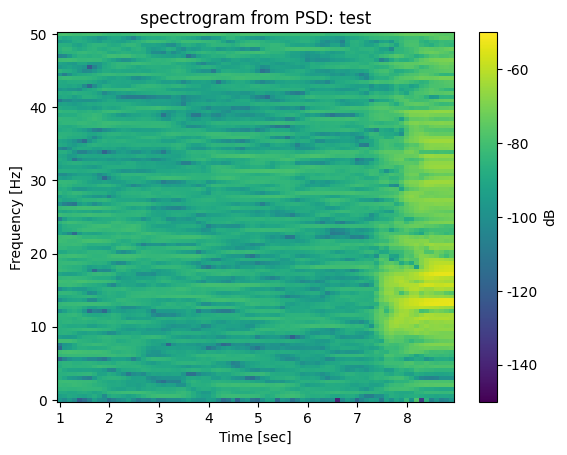

In [12]:
#plt.rcParams['figure.figsize'] = [3, 3]
show_image(frequencies, times, spectrogram, "test")

In [13]:
def evaluateSample(index, return_list):
  frequencies, times, spectrogram = __getitem(positives[index])
  out = run_one_image(frequencies, times, spectrogram, model_mae, True)
  return_list.append(out)

In [14]:
import multiprocessing
import copy

processes = []
manager = multiprocessing.Manager()
return_list= manager.list()
batchSize = 100
batches = math.floor(len(positives)/batchSize)
for batchNumber in tqdm(range(0, batches)):
    start= batchSize*batchNumber
    indexBatch = range(start,start+batchSize)
    for i in indexBatch:
        p = multiprocessing.Process(target = evaluateSample, args=(positives[i], return_list))
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

positivesMSE = copy.deepcopy(return_list)

  0%|          | 0/391 [19:25<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
processes = []
manager = multiprocessing.Manager()
return_list= manager.list()
batchSize = 100
batches = math.floor(len(noise)/batchSize)
for batchNumber in tqdm(range(0, batches)):
    start= batchSize*batchNumber
    indexBatch = range(start,start+batchSize)
    for i in indexBatch:
        p = multiprocessing.Process(target = evaluateSample, args=(noise[i], return_list))
        p.start()
        processes.append(p)

    for p in processes:
        p.join()